In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# 2장 시계열 데이터의 발견 및 다루기

누락값처리 / 샘플링

### 2-1) 누락된 시계열 데이터 생성하고, 채워보기

* Forward Fill
* Moving average
* Interpolation

In [3]:
#파일을 불러올 떄, 처음부터 parse_dates=리스트 형태로 주어줘서 datetime으로 가져올 수 있다(위치숫자로도 줄 수 있음)
un_rate = pd.read_excel("실업률(2장).xlsx", parse_dates=["Year"], index_col=0)
un_rate.index = un_rate.index.to_period()  # datetime 형태를 period로 바꿔 주면, 1977,1978 형태로 나타낼 수 있군
un_rate

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,6.4
1978,6.4,6.3,6.3,6.1,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.6,7.8,7.7,7.5,7.5,7.5,7.2


In [4]:
# stack을 통해서 시계열로 이쁘게 정렬할 수 있다
un_series = un_rate.stack()
un_series.head()

Year     
1977  Jan    7.5
      Feb    7.6
      Mar    7.4
      Apr    7.2
      May    7.0
dtype: float64

In [5]:
# 임으로 데이터를 누락한 데이터셋과 가장 높은 실업률을 기록한 월을 분리해보자
np.random.seed(33)
# 1. 임의로 누락
## 인덱스를 랜덤하게 뽑은 후, 그걸 정렬해서 추출
random_idx = np.random.permutation(len(un_series))[4:]
random_idx = np.sort(random_idx)
random_sample = un_series.copy()[random_idx].unstack() # unstack을 통해서 원래대로 되돌린다
random_sample

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,NaN,6.9,7.0,6.8,6.8,6.8,6.4
1978,6.4,6.3,6.3,NaN,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,6.0,NaN,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,NaN,7.6,7.8,7.7,7.5,7.5,7.5,7.2


In [6]:
# 2. 가장 실업률이 높은 월을 누락
## 참조) df.apply(axis=1) 이면 Column wise하게 함수를 날린다

arg_idx = un_rate.apply(np.argmax, axis=1)
max_sample = un_rate.copy()

# 조건에 맞는 특정 행의 열을 nan으로 바꿔준다 -> 반복문을 안돌리고도 할 수 있는 방법이 없을까?
for i,idx in enumerate(arg_idx.values):
    max_sample.iloc[i][idx] = np.nan

max_sample

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,NaN,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,6.4
1978,NaN,6.3,6.3,6.1,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,NaN,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.6,NaN,7.7,7.5,7.5,7.5,7.2


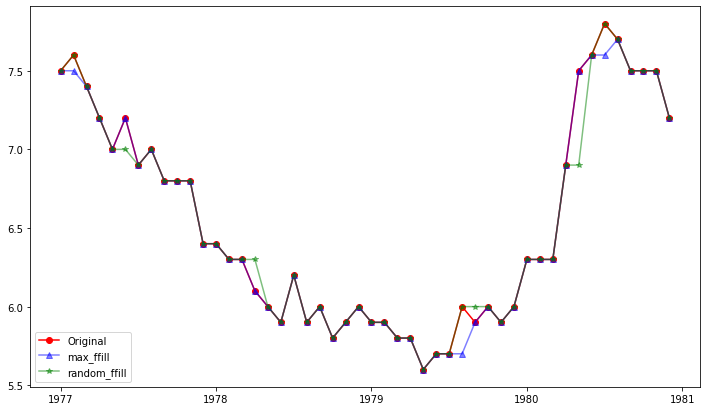

In [7]:
# 포워드필 -> 이전의 관측값으로 단순히 NaN 값을 채운다

# random_sample
random_sample_ffill = random_sample.ffill(axis=1)

# max_sample
max_sample2 = max_sample.copy() #1978 1월 값은 ffill이 채워 주지 못해서, stack을 해서 데이터프레임을 펼친 후, ffill을 수행하준다
max_sample_ffill = max_sample2.stack(dropna=False).ffill().unstack() # stack은 dropna=False가 기본값이기 때문에, 이를 지정해 주지 않으면 NaN값을 drop한다!

plt.figure(figsize=(12,7))
plt.plot(un_rate.stack().values, c='r', marker="o", label="Original")
plt.plot(max_sample_ffill.stack().values, c='b', marker="^", alpha=0.5,label="max_ffill")
plt.plot(random_sample_ffill.stack().values, c='g', marker="*", alpha=0.5, label="random_ffill")
plt.xticks([0,12,24,36,48], ["1977","1978","1979","1980", "1981"])
plt.legend();

In [8]:
# 이동평균 -> 노이즈가 많은 데이터인 경우 포워드필 보다는 이동평균을 사용해야 한다(평균은 노이즈의 일부를 제거할 수 있다)

# 1. random_sample 데이터프레임에 fillna를 rolling해준 것으로 해준다! rolling().mean()자체도 NaN을 리턴하기 때문에, fillna를 위해 min_periods=1로 설정해야 한다!
random_stack = random_sample.stack(dropna=False)
random_stack.fillna(random_stack.rolling(3, min_periods=1).mean()).unstack()

# 2.max_sample은 생략

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,7.1,6.9,7.0,6.80,6.8,6.8,6.4
1978,6.4,6.3,6.3,6.3,6.0,5.9,6.2,5.9,6.00,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,6.0,5.85,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,6.6,7.6,7.8,7.7,7.50,7.5,7.5,7.2


In [9]:
# 이동평균 (지수평균)
random_stack = random_sample.stack(dropna=False)
random_stack.fillna(random_stack.rolling(3, min_periods=1, win_type="exponential").mean()).unstack()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.000000,7.053788,6.9,7.0,6.800000,6.8,6.8,6.4
1978,6.4,6.3,6.3,6.3,6.000000,5.900000,6.2,5.9,6.000000,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.600000,5.700000,5.7,6.0,5.919318,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,6.738635,7.600000,7.8,7.7,7.500000,7.5,7.5,7.2


In [10]:
random_sample

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,NaN,6.9,7.0,6.8,6.8,6.8,6.4
1978,6.4,6.3,6.3,NaN,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,6.0,NaN,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,NaN,7.6,7.8,7.7,7.5,7.5,7.5,7.2


In [11]:
# 보간법
## 누락된 값을 대치할 때, 이미 알고 있는 지식에 기반하여 특정한 경향을 사용하게끔 제한할 수 있다. -> 시간에 따라 시스템이 동작하는 방식을 알고 있고, 그 지식을 활용할 때 특히 유용한 방식이다

random_sample.stack(dropna=False).interpolate("linear").unstack()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.20,7.00,6.95,6.9,7.0,6.8,6.8,6.8,6.4
1978,6.4,6.3,6.3,6.15,6.00,5.90,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.80,5.60,5.70,5.7,6.0,6.0,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.90,7.25,7.60,7.8,7.7,7.5,7.5,7.5,7.2


### 2-2) 샘플링

* 다운샘플링: 데이터의 빈도를 줄인다

* 업샘플링 : 데이터의 빈도를 늘린다 (Not Free Lunch -> 더 많은 시간 레이블을 얻을 수는 있지만, 더 많은 정보가 추가되는 것은 아니다)


* 판다스의 resample을 사용할 수 있다

In [12]:
# 다운 샘플링 예시) 시계열의 1월 부분에만 집중하는 경우
un_rate_stack = un_rate.copy().stack()

# 1월달 인덱스를 불리안으로 가져오기
jan_idx = un_rate_stack.index.get_level_values(1) == "Jan"

# 1월달 값만 추출하기 -> 1월달만 가져올 수 있다!!!
un_rate_stack[jan_idx]

Year     
1977  Jan    7.5
1978  Jan    6.4
1979  Jan    5.9
1980  Jan    6.3
dtype: float64

### 2-3) 데이터 평활

In [1]:
list(reversed(range(1,11)))

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]